In [1]:
import ot
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.base import clone
import seaborn as sns
from tqdm import tqdm, tqdm_notebook
from utils import construct_confidence_interval, plot_pies

import sklearn
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, StandardScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.manifold import TSNE
import seaborn as sns
import math

from mapper import full_repair, partial_repair, random_repair_original
from utils import balanced_error_rate, disparate_impact, likelihood_ratio
from utils import evaluate_metrics, evaluate_repair, plot_metrics
from functools import partial
import pickle as pl

In [2]:
from collections import Counter

In [3]:
nrows = None

10817
12776


lr
74265
15686

rf 21521

In [4]:
random_seed = 21521 #np.random.randint(0, 99999)
print(random_seed)

21521


In [5]:
numerical_features_index = [1, 2, 6, 12, 13]

In [6]:
data_train = pd.read_csv('../datasets/Australian Credit Approval/australian.dat', nrows=nrows, sep=' ', header=None)

data_train.drop_duplicates(inplace=True)

y_data = data_train.loc[:, data_train.columns[-1]]
protected_attribute = data_train.loc[:, data_train.columns[0]]

data_train.drop(data_train.columns.difference(numerical_features_index), axis=1, inplace=True)
data_train = data_train.astype(np.float64)

scaler = StandardScaler()

data = scaler.fit_transform(data_train)

shuffle_splitter = ShuffleSplit(n_splits=1, test_size=0.25, random_state=random_seed)

#for visualization purposes
data_transformed = TSNE(n_components=2).fit_transform(data)

In [7]:
#f, ax = plot_pies(data_train.values, protected_attribute, y_data, alpha=0.5)

In [8]:
#f.savefig('/home/grapefroot/Dropbox/Apps/Overleaf/writeup/img/australian_credit_approval.pgf', frameon=True, transparent=True, bbox_inches='tight')

In [9]:
for train_index, test_index in shuffle_splitter.split(data):
    data_train, data_test = data[train_index], data[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]
    protected_train, protected_test = protected_attribute[train_index], protected_attribute[test_index]
    tsne_train, tsne_test = data_transformed[train_index], data_transformed[test_index]
    break

In [10]:
print('Train shape', data_train.shape)

print('Test shape', data_test.shape)

Train shape (517, 5)
Test shape (173, 5)


In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from collections import Counter
from sklearn.model_selection import GridSearchCV

/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [12]:
# clf_base = RandomForestClassifier()#random_state=random_seed)

# param_grid = {
#     'n_estimators': [10, 50, 100, 200, 500, 1000],
#     'max_depth': [None, 2, 3, 4, 5, 6],
#     'min_samples_split': [2, 3, 4, 5]
# }
# CLF_NAME = 'Random Forest'

In [13]:
clf_base = GradientBoostingClassifier()

param_grid = {
    'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500, 1000],
    'min_samples_split': [2, 3, 4, 5],
    'max_depth':[None, 2, 3, 4, 5, 6]
}
CLF_NAME = 'Gradient Boosting'

In [14]:
# clf_base = LogisticRegression()
# param_grid = {
#     'penalty': ['l1', 'l2'],
#     'C':[0.01, 0.05, 0.1, 0.2, 0.5, 1],
# }
# CLF_NAME = 'Logistic Regression'

In [15]:
clf = GridSearchCV(clf_base, param_grid, n_jobs=-1, verbose=1, refit=True)
clf.fit(data_train, y_train)

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  1.0min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2], 'n_estimators': [100, 200, 500, 1000], 'min_samples_split': [2, 3, 4, 5], 'max_depth': [None, 2, 3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [16]:
clf_predictions = clf.predict(data_test)

In [17]:
accuracy_before = accuracy_score(y_test, clf_predictions)
di_before = disparate_impact(clf_predictions, protected_test)
print('Initial accuracy of classification: {}'.format(accuracy_before))
print('Initial DI: {}'.format(di_before))

Initial accuracy of classification: 0.7283236994219653
Initial DI: 0.8599498327759197


In [18]:
def di_acc_curve(clf, data, labels, protected):
    probas = clf.predict_proba(data)[:, 0]
    accuracy = []
    di = []
    for thresh in np.linspace(0.1, 0.9, num=100):
        predictions =  probas >= thresh
        accuracy.append(accuracy_score(labels, predictions))
        di.append(disparate_impact(predictions, protected))
    return accuracy, di

In [19]:
acc_curve, di_curve = di_acc_curve(clf, data_test, y_test, protected_test)

/home/grapefroot/ot-numerical-experiments/notebooks/utils.py:36: RuntimeWarning: invalid value encountered in double_scalars
  return d * (a + c) / c / (b + d)


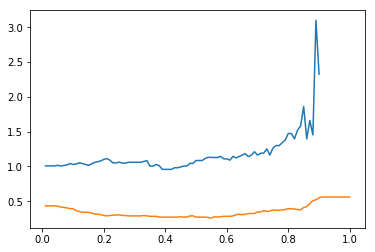

In [20]:
plt.plot(np.linspace(0.01, 1, num=100), di_curve)
plt.plot(np.linspace(0.01, 1, num=100), acc_curve)

In [21]:
negative_label = 0
positive_label = 1

In [22]:
male_entries_index = protected_train[protected_train == positive_label]
female_entries_index = protected_train[protected_train == negative_label]

male_entries_test_index = protected_test[protected_test == positive_label]
female_entries_test_index = protected_test[protected_test == negative_label]

n0 = data_train[protected_train == positive_label].shape[0]
n1 = data_train[protected_train == negative_label].shape[0]
n0_test = data_test[protected_test == positive_label].shape[0]
n1_test = data_test[protected_test == negative_label].shape[0]

emperical_histogram_male = np.ones_like(male_entries_index) / n0
emperical_histogram_female = np.ones_like(female_entries_index) / n1

emperical_histogram_male_test = np.ones_like(male_entries_test_index) / n0_test
emperical_histogram_female_test = np.ones_like(female_entries_test_index) / n1_test

In [23]:
C = ot.dist(data_test[protected_test == positive_label], data_test[protected_test == negative_label])

In [24]:
%%time
coupling = ot.emd(emperical_histogram_male_test, emperical_histogram_female_test, C, numItermax=1000000000)

CPU times: user 2.29 ms, sys: 0 ns, total: 2.29 ms
Wall time: 2.28 ms


In [25]:
def f(G):
    return 0.5 * np.sum(G**2)

def df(G):
    return G

In [26]:
#coupling1 = ot.optim.gcg(emperical_histogram_male_test, emperical_histogram_female_test, C / C.max(), reg1=1e-3, reg2=1e-1, f=f, df=df, verbose=True)
%time
#coupling1 = ot.stochastic.solve_semi_dual_entropic(emperical_histogram_male_test, emperical_histogram_female_test, C, reg=1, method='SAG', numItermax=100000, log=True)[0]

CPU times: user 0 ns, sys: 7 µs, total: 7 µs
Wall time: 12.9 µs


In [27]:
coupling1 = ot.bregman.sinkhorn(emperical_histogram_male_test, emperical_histogram_female_test, C / C.max(), reg=0.002)

In [28]:
coupling2 = ot.bregman.partial_transport(emperical_histogram_male_test, emperical_histogram_female_test, C / C.max(), reg=0.002, m=1)

In [29]:
y_first = y_test[protected_test == positive_label]
y_second = y_test[protected_test == negative_label]
print('class 0 size {}'.format(y_first.shape))
print('class 1 size {}'.format(y_second.shape))

class 0 size (121,)
class 1 size (52,)


In [30]:
from mapper import full_repair, partial_repair, random_repair_original
from utils import balanced_error_rate, disparate_impact, likelihood_ratio

from utils import evaluate_metrics, evaluate_repair, plot_metrics

from functools import partial

In [31]:
predicted_fairness_dict = {
    'DI': disparate_impact,
    'CI': partial(construct_confidence_interval, level=0.95),
}

accuracy_metrics_dict = {
    'Accuracy': accuracy_score,
}

In [32]:
from collections import defaultdict
from tqdm import tqdm
from functools import partial

In [33]:
partial_repair_func = lambda rv, c0, c1, y0, y1: partial_repair(rv, c0 ,c1, coupling, y0, y1)
random_repair_func = lambda rv, c0, c1, y0, y1: random_repair_original(c0, c1, coupling, y0, y1, theta=rv)
partial_repair_reg_func = lambda rv, c0, c1, y0, y1: partial_repair(rv, c0 ,c1, coupling1, y0, y1)
random_repair_reg_func = lambda rv, c0, c1, y0, y1: random_repair_original(c0, c1, coupling1, y0, y1, theta=rv)

partial_repair_reg_func_pt = lambda rv, c0, c1, y0, y1: partial_repair(rv, c0 ,c1, coupling2, y0, y1)
random_repair_reg_func_pt = lambda rv, c0, c1, y0, y1: random_repair_original(c0, c1, coupling2, y0, y1, theta=rv)

In [34]:
protected_test_new = np.concatenate((np.ones(y_first.shape[0]), np.zeros(y_second.shape[0])))

In [35]:
evaluation_1 = evaluate_repair(data_test[protected_test == positive_label], data_test[protected_test == negative_label], y_first, y_second, protected_test_new, partial_repair_func, clf, predicted_fairness_dict, accuracy_metrics_dict, name='full ot')

100%|██████████| 100/100 [00:00<00:00, 217.82it/s]


In [36]:
evaluation_2 = evaluate_repair(data_test[protected_test == positive_label], data_test[protected_test == negative_label], y_first, y_second, protected_test_new, random_repair_func, clf, predicted_fairness_dict, accuracy_metrics_dict, n_trials=10, name='random repair full ot')#

100%|██████████| 100/100 [00:04<00:00, 22.83it/s]


In [37]:
evaluation_3 = evaluate_repair(data_test[protected_test == positive_label], data_test[protected_test == negative_label], y_first, y_second, protected_test_new, partial_repair_reg_func, clf, predicted_fairness_dict, accuracy_metrics_dict, name='entropically regularized ot')

100%|██████████| 100/100 [00:00<00:00, 221.90it/s]


In [38]:
evaluation_4 = evaluate_repair(data_test[protected_test == positive_label], data_test[protected_test == negative_label], y_first, y_second, protected_test_new, random_repair_reg_func, clf, predicted_fairness_dict, accuracy_metrics_dict, n_trials=10, name='random repair regularized ot')

100%|██████████| 100/100 [00:04<00:00, 22.71it/s]


In [39]:
evaluation_5 = evaluate_repair(data_test[protected_test == positive_label], data_test[protected_test == negative_label], y_first, y_second, protected_test_new, partial_repair_reg_func_pt, clf, predicted_fairness_dict, accuracy_metrics_dict, name='partial repair regularized ot')

100%|██████████| 100/100 [00:00<00:00, 220.03it/s]


In [40]:
evaluation_6 = evaluate_repair(data_test[protected_test == positive_label], data_test[protected_test == negative_label], y_first, y_second, protected_test_new, random_repair_reg_func_pt, clf, predicted_fairness_dict, accuracy_metrics_dict, n_trials=10, name='random repair partial regularized ot')

100%|██████████| 100/100 [00:04<00:00, 22.68it/s]


In [41]:
# ot_mapping_linear = ot.da.LinearTransport()

# ot_mapping_linear.fit(Xs = data_train[protected_train == positive_label], Xt=data_train[protected_train == negative_label])

# ot_mapping_linear.inverse_transform(Xs = np.ones((10, 5)))

# transformed_data = 0.5 * data_test[protected_test == positive_label] + 0.5 * ot_mapping_linear.transform(data_test[protected_test == positive_label])
# transformed_data_1 = 0.5 * data_test[protected_test == negative_label] + 0.5 * ot_mapping_linear_1.transform(data_test[protected_test == negative_label])

# disparate_impact(clf.predict(np.concatenate((transformed_data, transformed_data_1))), protected_test_new)

In [42]:
XX, yy = partial_repair_reg_func_pt(1, data_test[protected_test == positive_label], data_test[protected_test == negative_label], y_first, y_second)
disparate_impact(clf.predict(XX), protected_test_new)

1.0180288461538463

In [43]:
print('{} & {:.3f} & {:.3f} & {:.3f} & {:.3f}'.format(CLF_NAME, accuracy_before, di_before, evaluation_1['Accuracy'][-1], evaluation_1['DI'][-1]))
print('{} & {:.3f} & {:.3f} & {:.3f} & {:.3f}'.format(CLF_NAME, accuracy_before, di_before, evaluation_3['Accuracy'][-1], evaluation_3['DI'][-1]))
print('{} & {:.3f} & {:.3f} & {:.3f} & {:.3f}'.format(CLF_NAME, accuracy_before, di_before, evaluation_5['Accuracy'][-1], evaluation_5['DI'][-1]))

Gradient Boosting & 0.728 & 0.860 & 0.671 & 1.062
Gradient Boosting & 0.728 & 0.860 & 0.694 & 1.138
Gradient Boosting & 0.728 & 0.860 & 0.694 & 1.018


In [44]:
couplings = {}

In [45]:
for rv in tqdm(np.linspace(0.01, 1, num=100)):
    coupling = ot.bregman.partial_transport(emperical_histogram_male_test, emperical_histogram_female_test, C / C.max(), reg=0.002, verbose=False, log=False, m=rv)
    couplings[rv] = coupling

100%|██████████| 100/100 [00:01<00:00, 50.56it/s]


In [46]:
def new_repair(rv, c0, c1, y0, y1, verbose=False, *args, **kwargs):
    p_marginal = couplings[rv].sum(axis=1) / rv
    q_marginal = couplings[rv].sum(axis=0) / rv
    relative_size = p_marginal.shape[0] / q_marginal.shape[0]
    p_marginal /= relative_size
    
    mask_threshold = np.percentile(np.concatenate((p_marginal, q_marginal)), (1 - rv) * 100)
    mask1 = (p_marginal >= mask_threshold)
    mask2 = (q_marginal >= mask_threshold)
    if verbose:
        print('rv: {} mask1: {} mask2: {}'.format(rv, mask1.mean(), mask2.mean()))
    return partial_repair(1, c0, c1, couplings[rv], y0, y1, mask=np.concatenate((mask1, mask2))[:, np.newaxis])

# def new_repair_random(rv, c0, c1, y0, y1, *args, **kwargs):
#     p_marginal = couplings[rv].sum(axis=1) / rv
#     q_marginal = couplings[rv].sum(axis=0) / rv
#     relative_size = p_marginal.shape[0] / q_marginal.shape[0]
#     p_marginal /= relative_size
    
#     mask_threshold = np.percentile(np.concatenate((p_marginal, q_marginal)), (1 - rv) * 100)
#     mask1 = (p_marginal >= mask_threshold)
#     mask2 = (q_marginal >= mask_threshold)
# #     if kwargs['verbose']:
#     print('rv: {} mask1: {} mask2: {}'.format(rv, mask1.mean(), mask2.mean()))
#     return random_repair_original(c0, c1, coupling, y0, y1, mask=np.concatenate((mask1, mask2))[:, np.newaxis], theta=rv)

100%|██████████| 30/30 [00:00<00:00, 455.12it/s]


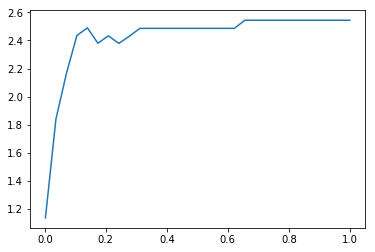

In [47]:
dis_t = []
ls = np.linspace(0.002, 1, num=30)
for rv in tqdm(np.linspace(0.002, 1, num=30)):
    coupling_t = ot.bregman.sinkhorn(emperical_histogram_male_test, emperical_histogram_female_test, C / C.max(), reg=rv, verbose=False, log=False, m=1)
    XX, yy = partial_repair(1, data_test[protected_test == positive_label], data_test[protected_test == negative_label], coupling_t, y_first, y_second)
    dis_t.append(disparate_impact(clf.predict(XX), protected_test_new))
    
plt.plot(ls, dis_t)

In [48]:
evaluation_7  = evaluate_repair(data_test[protected_test == positive_label], data_test[protected_test == negative_label], y_first, y_second, protected_test_new, new_repair, clf, predicted_fairness_dict, accuracy_metrics_dict, name='subset repair')

100%|██████████| 100/100 [00:00<00:00, 215.35it/s]


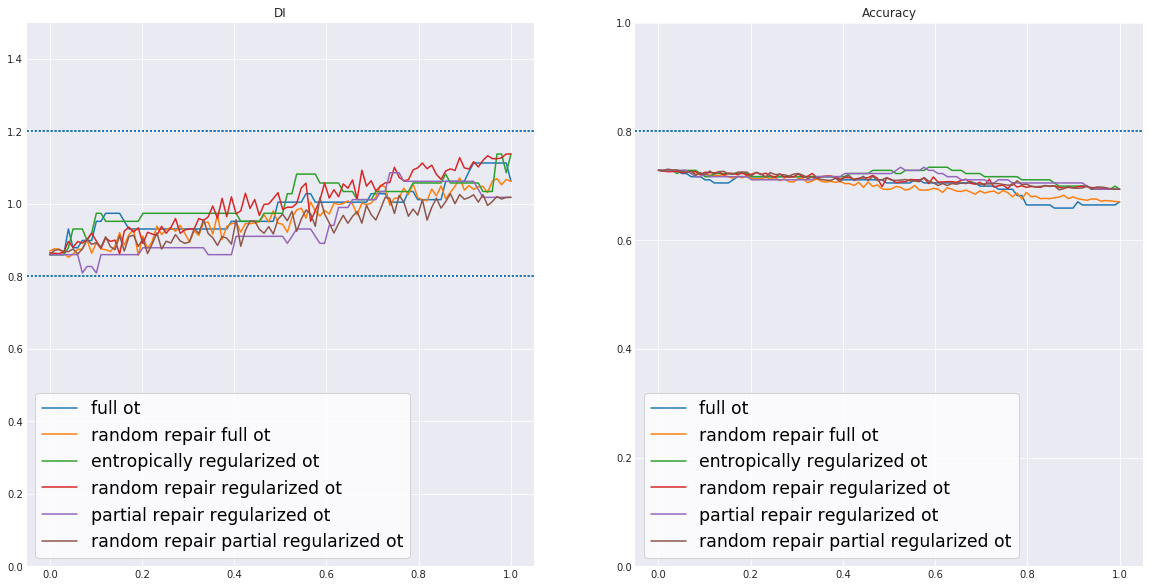

In [49]:
fig, aaaa = plot_metrics([evaluation_1, evaluation_2, evaluation_3, evaluation_4, evaluation_5, evaluation_6], what_to_plot=['DI', 'Accuracy'], subplot_shape=(1, 2), subplot_size=(20, 10))
aaaa[1].set_ylim(0, 1)
aaaa[0].legend(fontsize='xx-large', loc='best')
aaaa[1].legend(fontsize='xx-large', loc='best')

In [50]:
fig.savefig('/home/grapefroot/Dropbox/Apps/Overleaf/writeup/img/australian_credit_lr.pgf', frameon=True, bbox_inches='tight')

In [51]:
with open('/home/grapefroot/Dropbox/Apps/Overleaf/writeup/img/australian_credit_lr.pickle', mode='wb') as file:
    pl.dump(fig, file)

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f17c73bb198>)

<Figure size 1440x1440 with 0 Axes>

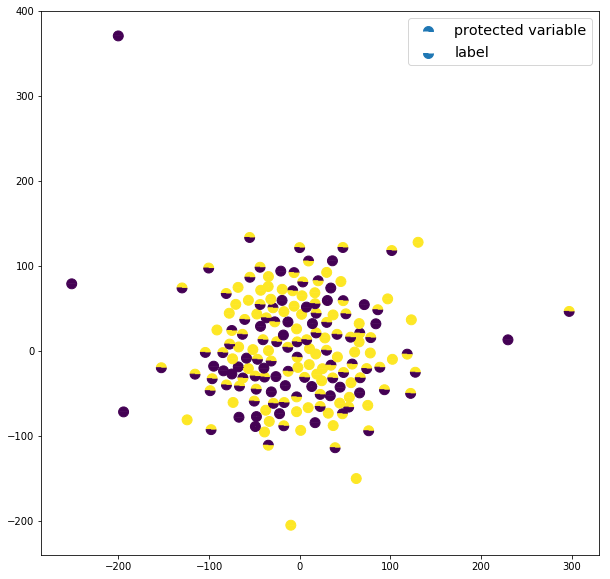

In [50]:
plot_pies(TSNE(n_components=2).fit_transform(data_test), protected_test, y_test)

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f17c7314b38>)

<Figure size 1440x1440 with 0 Axes>

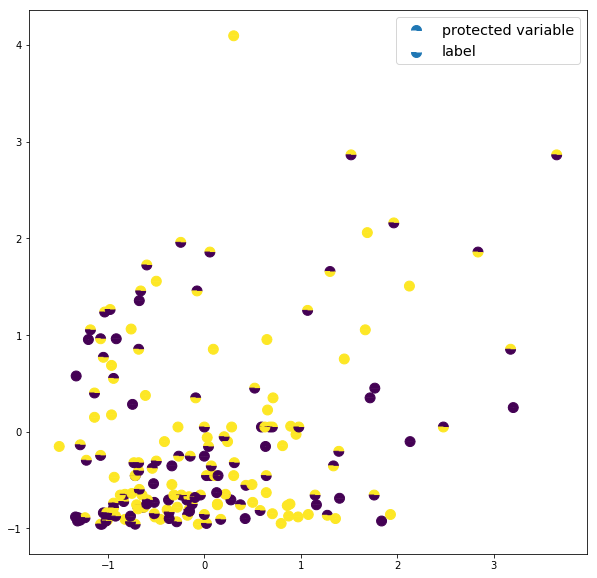

In [51]:
plot_pies(data_test, protected_test, y_test)